# Shopify Fall 2022 Data Science Intern Challenge (Part 1)

Please consider donating to the **Palestine Emergency Appeal**. The smallest of contributions can make the most profound of impacts.

<a href="https://www.islamicreliefcanada.org/emergencies/palestine/" target="_blank" rel="noopener noreferrer" style="color: white; background-color: salmon; border-radius: 5px; padding: 5px;">Donate to Palestine</a>

## Challenge

Given some sample data, write a program to answer the following: [click here to access the required data set](https://docs.google.com/spreadsheets/d/16i38oonuX1y1g7C_UAmiK9GkY7cS-64DfiDMNiR41LM/edit#gid=0)

On Shopify, we have exactly 100 sneaker shops, and each of these shops sells only one model of shoe. We want to do some analysis of the average order value (AOV). When we look at orders data over a 30 day window, we naively calculate an AOV of $3145.13. Given that we know these shops are selling sneakers, a relatively affordable item, something seems wrong with our analysis.

- Think about what could be going wrong with our calculation. Think about a better way to evaluate this data.
- What metric would you report for this dataset?
- What is its value?

## Loading the Data

Let's begin by importing some essential packages and configuring our notebook.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

default_fig_size = (16, 5)
sns.set()
mpl.rcParams['figure.figsize'] = default_fig_size

We can start by importing our dataset and displaying the first few entries.

In [2]:
# URL to spreadsheet
spreadsheet_url = 'https://docs.google.com/spreadsheets/d/16i38oonuX1y1g7C_UAmiK9GkY7cS-64DfiDMNiR41LM/edit#gid=0'
# set up spreadsheet to export CSV
spreadsheet_csv_url = spreadsheet_url.replace('/edit#gid=', '/export?format=csv&gid=')

# download and parse CSV
orders_df = pd.read_csv(spreadsheet_csv_url)
# change create_at column to datetime object
orders_df['created_at'] = pd.to_datetime(orders_df['created_at'])
# show first five entries
orders_df.head()

,order_id,shop_id,user_id,order_amount,total_items,payment_method,created_at
0,1,53,746,224,2,cash,2017-03-13 12:36:56
1,2,92,925,90,1,cash,2017-03-03 17:38:52
2,3,44,861,144,1,cash,2017-03-14 04:23:56
3,4,18,935,156,1,credit_card,2017-03-26 12:43:37
4,5,18,883,156,1,credit_card,2017-03-01 04:35:11


Looks like the dataset contains order data with the corresponding shop and user IDs, as well as other information regarding the purchase. Nothing too out of the ordinary!

We can go ahead and compute the AOV (average order value). But before we do that, let's talk about what it is!

## AOV (Average Order Value)

AOV, or average order value, is an ecommerce metric that provides an idea of the amount of revenue earned from each order, and is calculated using the following formula:

$\text{AOV} = \frac{\text{Revenue Earned}}{\text{Number of Orders}}$

It's worth noting that this isn't some magic metric and the context of its use is very important, as is true for pretty much any statistical metric! In this document, we will test its effectiveness and provide possible corrections or alternative metrics to evaluate the success of a business.

## Naive Computation

For starters, let's get to evaluating the "naive" method described in the original question. In order to naively compute AOV, we will simply compute the mean of `order_amount`.

In [3]:
# naively compute mean
AOV = orders_df['order_amount'].mean()
print('Naive AOV: ', AOV)

Naive AOV:  3145.128


This is the same value mentioned in the question. As was also mentioned in the question, this value does not seem right. An average value of \\$3145.128 is not very insightful, especially because this seems to be an overestimation for sneaker prices. I doubt the average person is willing to pay three-thousand dollars for a pair of sneakers!

# So What's Wrong?

In order to investigate what's going on, let's take a closer look at our data. We'll do this by constructing a kernel density estimate plot of `order_amount`.

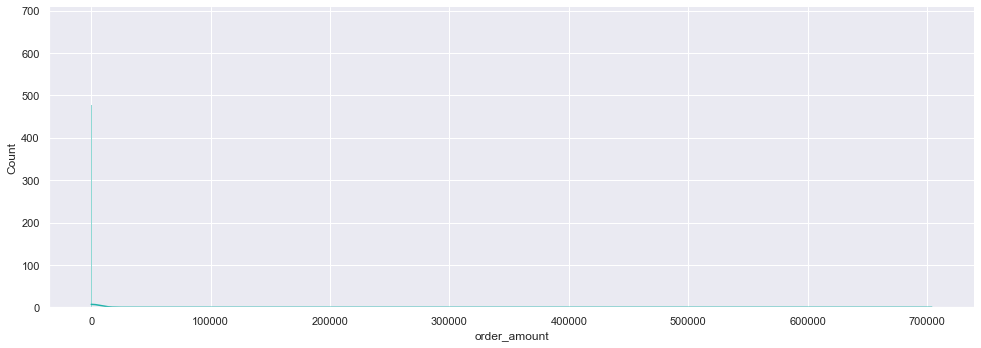

In [4]:
# construct kernel density estimate plot
sns.displot(orders_df['order_amount'], kde=True, color='lightseagreen')
plt.gcf().set_size_inches(*default_fig_size)
plt.show()

That's weird! There's a massive, but narrow spike in density for very small order amounts. This means that most of our data is concentrated in the left, with some outliers to the right. Let's confirm this conjecture. We can do so by limiting `order_amount` to be less than \\$1000 and removing any outliers.

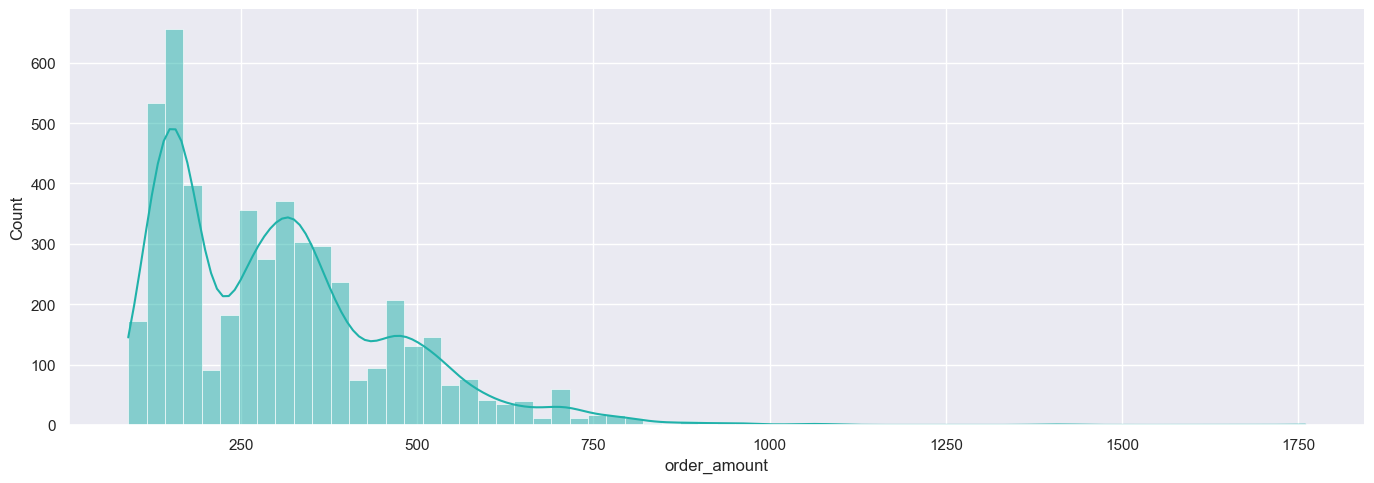

In [5]:
# filter by orders that cost less than $10000
order_amount = orders_df['order_amount']
order_amount = order_amount[order_amount < 10000]

# construct kernel density estimate plot
sns.displot(order_amount, kde=True, color='lightseagreen')
plt.gcf().set_size_inches(*default_fig_size)
plt.show()

That makes a lot more sense! This confirms our outliers theory, which implies that most of the orders are between \\$100 to \\$800.

## A Better AOV Computation

Another observation we can make is that, along with the `order_amount` column in our data, there exists also a `total_items` column. Given the context, this column likely specifies the number of items bought in that order. That would totally explain why some purchases have been so expensive!

Let's compute a better AOV. Instead of taking the average of `order_amount`, let's take the average of `order_amount` per `total_items`.

In [6]:
# compute better AOV
AOV = orders_df['order_amount'].sum() / orders_df['total_items'].sum()
print('Better AOV: ', AOV)

Better AOV:  357.92152221412965


That looks much better!

## Daily AOV Variation

But what good is a single-valued metric based on years worth of data? We don't know how this value is changing in the short term. As a business-owner, am I profiting? Is my business declining? Do I need to spike up my prices?

To visualize the variation of this metric over time, we can compute and plot the daily AOV!

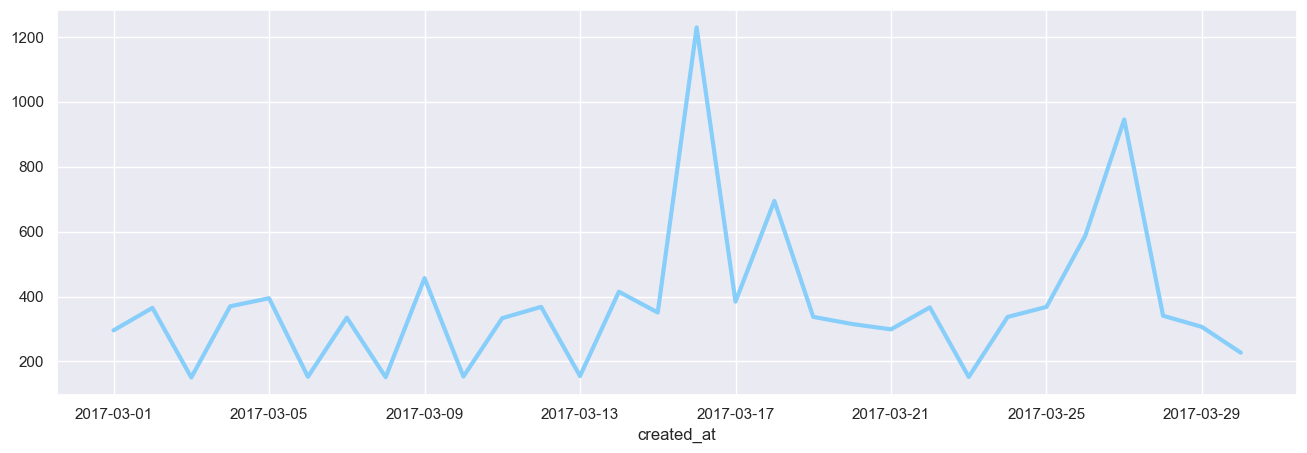

In [7]:
# group orders by date
orders_groupby_date = orders_df.groupby(orders_df['created_at'].dt.date)
# compute AOV by date
daily_AOV = orders_groupby_date.apply(lambda row: row['order_amount'].sum() / row['total_items'].sum())

# construct line plot
daily_AOV.plot(kind='line', color='lightskyblue', linewidth=3)
plt.show()

## AOV By Shop

According to the problem description, Shopify has exactly a hundred sneaker shops, each of which sells exactly one brand of sneakers. This could imply that the cross-correlation between each of these shops' sales is minimal and it makes no sense to group all shops together in our analysis. Thus, it may be worthwhile computing the AOVs for each `shop_id` to investigate the performance of each shop.

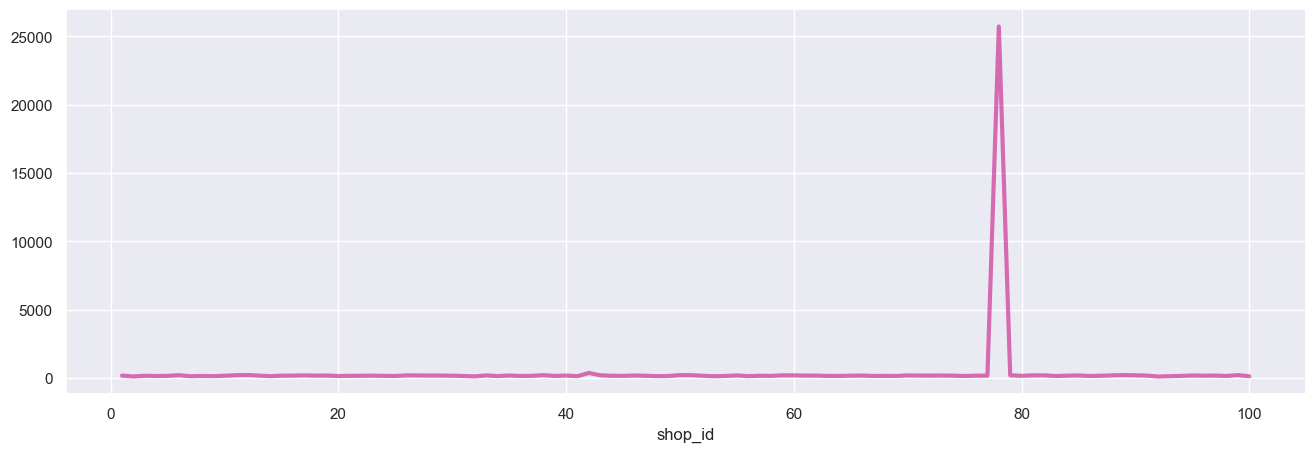

In [8]:
# group orders by shop
orders_groupby_shop = orders_df.groupby('shop_id')
# compute AOV by shop
per_shop_AOV = orders_groupby_shop.apply(lambda row: row['order_amount'].sum() / row['total_items'].sum())

# construct line plot
per_shop_AOV.plot(kind='line', color='mediumvioletred', linewidth=3, alpha=0.6)
plt.show()

Looks like shop number 78 is selling really expensive sneakers (or it's a data entry error)!